In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [86]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # GPU를 비활성화

In [3]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

output_dir = "myLearningData/savefig/3line/LargeData/fine"  # 저장할 폴더 이름
if not os.path.exists(output_dir): # 폴더가 없는 경우 폴더를 생성합니다.
    os.makedirs(output_dir)
data = '240206_0236_3line_100ms22C_I2C'
datanickname = 'PReLU_N64Op3LR6Adam_wo1'
dataname = data+datanickname
filename = 'myData/'+data+'.csv'
SDreal = pd.read_csv(filename)
SDreal=SDreal.iloc[:,:40]
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx46,Sx47,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r
count,298215.000000,298215.000000,298215.000000,298215.000000,298215.00000,298215.000000,298215.000000,298215.000000,298215.000000,298215.000000,...,298215.000000,298215.000000,298215.000000,298215.000000,298215.000000,298215.000000,298215.000000,298215.000000,298215.000000,298215.000000
mean,71.579147,70.384356,62.877513,65.825403,60.53938,65.119535,69.816413,70.161085,74.789063,60.592360,...,64.341458,61.322624,62.732384,62.850648,65.060482,69.613117,1.475001,87.208065,177.152189,5.994628
std,1.089497,1.060796,1.220403,0.914536,1.15545,1.052081,1.361106,1.146458,1.000644,0.933616,...,1.131415,1.069492,1.236467,1.123549,1.027373,1.269680,1.179124,43.826821,103.949291,3.162714
min,55.980000,55.240000,45.450000,54.950000,46.55000,50.840000,51.810000,54.760000,59.940000,44.340000,...,48.980000,45.120000,47.450000,46.000000,45.570000,51.120000,-5.308200,15.000000,0.000000,1.000000
25%,71.220000,69.940000,62.210000,65.350000,60.04000,64.670000,69.300000,69.700000,74.250000,60.210000,...,63.800000,60.940000,62.010000,62.380000,64.650000,69.020000,0.355900,47.000000,85.000000,3.000000
50%,71.720000,70.490000,62.910000,65.890000,60.71000,65.200000,69.980000,70.300000,74.830000,60.670000,...,64.390000,61.420000,62.750000,62.950000,65.160000,69.710000,1.343800,87.000000,175.000000,6.000000
75%,72.160000,70.990000,63.630000,66.390000,61.25000,65.710000,70.580000,70.820000,75.410000,61.110000,...,65.000000,61.870000,63.510000,63.470000,65.620000,70.360000,2.473300,127.000000,265.000000,9.000000
max,74.790000,73.840000,67.300000,69.840000,64.09000,69.520000,74.610000,74.230000,78.240000,65.400000,...,68.140000,64.810000,69.810000,66.790000,67.990000,73.620000,4.230200,159.000000,355.000000,11.000000


In [4]:
# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]


#SDreal = SDreal[~((SDreal <= -400) & (SDreal.columns == "Force")).any(axis=1)]
#SDreal = SDreal[~((SDreal >= 400) & (SDreal.columns == "Force")).any(axis=1)]
#SDreal['Force'] = SDreal['Force'].apply(lambda x: 0 if x < 0 else x)
SDreal = SDreal[~((SDreal <= 1) & (SDreal.columns == "Force")).any(axis=1)]

SDreal = SDreal[SDreal["r"] >= 1]
SDreal = SDreal[SDreal["r"] <= 12]

SDreal = SDreal[SDreal["z"] <= 160]
SDreal = SDreal[SDreal["z"] >= 0]

import numpy as np
toRad = np.pi/180.0
SDreal['cos']=np.cos(SDreal['theta']*toRad)
SDreal['sin']=np.sin(SDreal['theta']*toRad)
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r,cos,sin
count,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,...,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,1.736170e+05,173617.000000
mean,71.550038,70.449628,62.772641,65.844989,60.652318,65.095170,69.824863,70.170236,74.876939,60.563995,...,62.662862,62.842158,65.048246,69.579673,2.304949,84.404033,178.248184,7.858954,1.758593e-03,-0.000189
std,1.205639,1.182669,1.217432,0.959187,1.211375,1.182347,1.519184,1.218220,1.068323,1.043627,...,1.278286,1.261793,1.160159,1.418521,0.816071,36.816865,104.252157,2.198691,7.128353e-01,0.701333
min,55.980000,55.240000,45.450000,54.950000,46.550000,50.840000,51.810000,54.760000,59.940000,44.340000,...,47.450000,46.000000,45.570000,51.120000,1.000100,15.000000,0.000000,4.000000,-1.000000e+00,-1.000000
25%,71.250000,70.050000,62.180000,65.390000,60.220000,64.670000,69.400000,69.770000,74.370000,60.210000,...,61.980000,62.410000,64.690000,69.020000,1.573500,55.000000,90.000000,6.000000,-7.071068e-01,-0.707107
50%,71.710000,70.590000,62.850000,65.930000,60.830000,65.210000,70.040000,70.330000,74.940000,60.680000,...,62.700000,62.980000,65.180000,69.730000,2.243300,87.000000,180.000000,8.000000,6.123234e-17,0.000000
75%,72.140000,71.090000,63.490000,66.420000,61.350000,65.720000,70.610000,70.820000,75.500000,61.110000,...,63.430000,63.500000,65.630000,70.370000,2.998900,119.000000,270.000000,10.000000,7.071068e-01,0.707107
max,74.350000,73.840000,67.300000,69.490000,64.090000,69.520000,74.610000,73.520000,78.070000,65.400000,...,69.810000,66.790000,67.990000,73.620000,4.230200,159.000000,355.000000,11.000000,1.000000e+00,1.000000


In [5]:
NUMSEN = 36
# 24개의 특성에 대한 평균과 표준편차를 계산합니다.
mean_values = SDreal.iloc[:, :NUMSEN].mean().values
std_values = SDreal.iloc[:, :NUMSEN].std().values

mean_values = [round(value, 2) for value in mean_values]
std_values = [round(value, 2) for value in std_values]

print("float Xmean[36] = {", ", ".join(map(str, mean_values)), "};")
print("float Xstd[36] = {", ", ".join(map(str, std_values)), "};")

min_max_F = [round(SDreal.iloc[:, NUMSEN].min(), 2), round(SDreal.iloc[:, NUMSEN].max(), 2)]
min_max_Z = [round(SDreal.iloc[:, NUMSEN+1].min(), 2), round(SDreal.iloc[:, NUMSEN+1].max(), 2)]

print("float Fminmax[2]={", ", ".join(map(str, min_max_F)), "};")
print("float Zminmax[2]={", ", ".join(map(str, min_max_Z)), "};")

float Xmean[36] = { 71.55, 70.45, 62.77, 65.84, 60.65, 65.1, 69.82, 70.17, 74.88, 60.56, 64.54, 65.01, 71.27, 63.38, 72.04, 68.8, 67.84, 58.74, 65.78, 70.81, 63.9, 57.79, 64.15, 62.46, 71.76, 71.32, 72.3, 69.25, 70.58, 61.61, 64.25, 61.31, 62.66, 62.84, 65.05, 69.58 };
float Xstd[36] = { 1.21, 1.18, 1.22, 0.96, 1.21, 1.18, 1.52, 1.22, 1.07, 1.04, 1.07, 1.24, 1.56, 1.41, 2.12, 1.69, 1.56, 1.94, 1.81, 1.97, 2.56, 3.1, 2.84, 1.68, 1.42, 1.41, 1.52, 1.54, 1.39, 1.36, 1.23, 1.23, 1.28, 1.26, 1.16, 1.42 };
float Fminmax[2]={ 1.0, 4.23 };
float Zminmax[2]={ 15, 159 };


In [6]:
def apply_transformation(df, columns, transformation):
    # columns가 제공되지 않았다면 df의 모든 칼럼을 대상으로 함
    if columns is None:
        columns = df.columns
    for column in columns:
        df[column] = transformation(df[column])
    return df

def normalize(column):
    return (column - column.min()) / (column.max() - column.min())
def standardize(column):
    return (column - column.mean()) / column.std()
def submean(column):
    return (column - column.mean())
def normalize_to_neg1_to_1(column):
    normalized = (column - column.min()) / (column.max() - column.min())  # Min-Max normalization (0 to 1)
    return (normalized - 0.5) * 2  # Transform to -1 to 1


SDreal = apply_transformation(SDreal.copy(), ['r', 'Force', 'z'], normalize_to_neg1_to_1)
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r,cos,sin
count,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,...,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,173617.000000,1.736170e+05,173617.000000
mean,71.550038,70.449628,62.772641,65.844989,60.652318,65.095170,69.824863,70.170236,74.876939,60.563995,...,62.662862,62.842158,65.048246,69.579673,-0.192069,-0.036055,178.248184,0.102558,1.758593e-03,-0.000189
std,1.205639,1.182669,1.217432,0.959187,1.211375,1.182347,1.519184,1.218220,1.068323,1.043627,...,1.278286,1.261793,1.160159,1.418521,0.505292,0.511345,104.252157,0.628198,7.128353e-01,0.701333
min,55.980000,55.240000,45.450000,54.950000,46.550000,50.840000,51.810000,54.760000,59.940000,44.340000,...,47.450000,46.000000,45.570000,51.120000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000e+00,-1.000000
25%,71.250000,70.050000,62.180000,65.390000,60.220000,64.670000,69.400000,69.770000,74.370000,60.210000,...,61.980000,62.410000,64.690000,69.020000,-0.644965,-0.444444,90.000000,-0.428571,-7.071068e-01,-0.707107
50%,71.710000,70.590000,62.850000,65.930000,60.830000,65.210000,70.040000,70.330000,74.940000,60.680000,...,62.700000,62.980000,65.180000,69.730000,-0.230241,0.000000,180.000000,0.142857,6.123234e-17,0.000000
75%,72.140000,71.090000,63.490000,66.420000,61.350000,65.720000,70.610000,70.820000,75.500000,61.110000,...,63.430000,63.500000,65.630000,70.370000,0.237609,0.444444,270.000000,0.714286,7.071068e-01,0.707107
max,74.350000,73.840000,67.300000,69.490000,64.090000,69.520000,74.610000,73.520000,78.070000,65.400000,...,69.810000,66.790000,67.990000,73.620000,1.000000,1.000000,355.000000,1.000000,1.000000e+00,1.000000


In [7]:
SDy = SDreal.iloc[:,36:42]
X = SDreal.iloc[:,0:36]
y = SDreal.iloc[:,[36,37,40,41]]
y

,Force,z,cos,sin
160,-0.828674,-1.0,1.000000,0.000000
161,-0.836290,-1.0,1.000000,0.000000
162,-0.841739,-1.0,1.000000,0.000000
163,-0.846011,-1.0,1.000000,0.000000
164,-0.849602,-1.0,1.000000,0.000000
...,...,...,...,...
289447,-0.720566,1.0,-0.906308,0.422618
289448,-0.721866,1.0,-0.906308,0.422618
289449,-0.722857,1.0,-0.906308,0.422618
292497,-0.994923,1.0,-0.707107,-0.707107


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.25, random_state=42)
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)
y_train = y_train.values
print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  104169 ea 59 %    X_valid:  34724 ea 20 %    X_test:  34724 ea 20 %


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/240206_0236_3line_100ms22C_I2CPReLU_N64Op3LR6Adam_wo1_SS.pkl']

In [10]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Dense(64, input_shape=X_train.shape[1:], kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),

    keras.layers.Dense(4)
])

model.compile(loss="mean_squared_error", optimizer='adam')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2368      
                                                                 
 p_re_lu (PReLU)             (None, 64)                64        
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 p_re_lu_1 (PReLU)           (None, 32)                32        
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 p_re_lu_2 (PReLU)           (None, 32)                32        
                                                                 
 dense_3 (Dense)             (None, 32)                1

## Callback (best, early stopping, tensorboard)

In [11]:
import math
from tensorflow import keras

# 콜백 정의
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

# ReduceLROnPlateau 콜백 정의
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.0001
)

# 모델 훈련
history = model.fit(
    X_train, y_train, epochs=1000,
    validation_data=(X_valid, y_valid),
    batch_size=256,  # 배치 크기 설정
    callbacks=[early_stopping_cb, reduce_lr]
)


# 모델 평가
mse_test = model.evaluate(X_test, y_test)

# 샘플 예측
X_new = X_test[:5]
y_pred = model.predict(X_new)


Epoch 1/1000
407/407 [==============================] - 5s 7ms/step - loss: 0.1755 - val_loss: 0.0921 - lr: 0.0010
Epoch 2/1000
407/407 [==============================] - 3s 7ms/step - loss: 0.0753 - val_loss: 0.0639 - lr: 0.0010
Epoch 3/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0577 - val_loss: 0.0533 - lr: 0.0010
Epoch 4/1000
407/407 [==============================] - 3s 7ms/step - loss: 0.0497 - val_loss: 0.0481 - lr: 0.0010
Epoch 5/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0451 - val_loss: 0.0443 - lr: 0.0010
Epoch 6/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0420 - val_loss: 0.0424 - lr: 0.0010
Epoch 7/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0396 - val_loss: 0.0399 - lr: 0.0010
Epoch 8/1000
407/407 [==============================] - 3s 7ms/step - loss: 0.0377 - val_loss: 0.0382 - lr: 0.0010
Epoch 9/1000
407/407 [==============================] - 3s 7ms/step - loss: 0.03

407/407 [==============================] - 3s 9ms/step - loss: 0.0191 - val_loss: 0.0231 - lr: 2.5000e-04
Epoch 69/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0188 - val_loss: 0.0229 - lr: 1.2500e-04
Epoch 70/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0188 - val_loss: 0.0228 - lr: 1.2500e-04
Epoch 71/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0188 - val_loss: 0.0228 - lr: 1.2500e-04
Epoch 72/1000
407/407 [==============================] - 3s 7ms/step - loss: 0.0187 - val_loss: 0.0229 - lr: 1.2500e-04
Epoch 73/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0187 - val_loss: 0.0228 - lr: 1.2500e-04
Epoch 74/1000
402/407 [============================>.] - ETA: 0s - loss: 0.0187
Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0001.
407/407 [==============================] - 3s 9ms/step - loss: 0.0187 - val_loss: 0.0228 - lr: 1.2500e-04
Epoch 75/1000
407/407 [=======================

407/407 [==============================] - 3s 7ms/step - loss: 0.0182 - val_loss: 0.0226 - lr: 1.0000e-04
Epoch 136/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0182 - val_loss: 0.0226 - lr: 1.0000e-04
Epoch 137/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0182 - val_loss: 0.0226 - lr: 1.0000e-04
Epoch 138/1000
407/407 [==============================] - 3s 8ms/step - loss: 0.0182 - val_loss: 0.0226 - lr: 1.0000e-04
Epoch 139/1000
407/407 [==============================] - 4s 9ms/step - loss: 0.0182 - val_loss: 0.0226 - lr: 1.0000e-04
Epoch 140/1000
407/407 [==============================] - 2s 6ms/step - loss: 0.0182 - val_loss: 0.0226 - lr: 1.0000e-04
Epoch 141/1000
407/407 [==============================] - 3s 7ms/step - loss: 0.0181 - val_loss: 0.0225 - lr: 1.0000e-04
Epoch 141: early stopping
1/1 [==============================] - 0s 118ms/step


In [12]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v3/myModel/'+dataname+'.h5')

In [13]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)
valid_predictions_df=pd.DataFrame(valid_predictions)
#valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df.columns = ["valid_force","valid_z","valid_cos","valid_sin"]
#valid_predictions_df.columns = ["valid_z","valid_cos","valid_sin"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r","valid_cos","valid_sin"]
valid_theta_rad = np.arctan2(valid_predictions_df['valid_sin'], valid_predictions_df['valid_cos'])
valid_theta_deg = np.degrees(valid_theta_rad)
valid_predictions_df['valid_theta'] = valid_theta_deg
valid_predictions_df['valid_theta'] /= 180
valid_predictions_df['valid_square'] = valid_predictions_df['valid_cos']**2 + valid_predictions_df['valid_sin']**2
valid_predictions_df.describe()

1086/1086 [==============================] - 3s 3ms/step


,valid_force,valid_z,valid_cos,valid_sin,valid_theta,valid_square
count,34724.000000,34724.000000,34724.000000,34724.000000,34724.000000,34724.000000
mean,-0.182574,-0.041937,-0.000594,-0.001739,0.000491,0.975769
std,0.461436,0.497589,0.702823,0.694142,0.580050,0.092875
min,-1.140363,-1.157775,-1.082660,-1.141453,-0.999956,0.000781
25%,-0.591119,-0.459561,-0.705616,-0.680389,-0.506465,0.948166
50%,-0.235132,-0.033730,-0.002921,-0.005470,-0.004820,0.984451
75%,0.227482,0.383739,0.704672,0.681549,0.496376,1.019799
max,1.002943,1.042658,1.116840,1.167475,0.999932,1.476266


In [14]:
k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
k_df.columns  = ["force","z","cos","sin"]
#k_df.columns  = ["z","cos","sin"]

#k_df.columns  = ["force","z","r","cos","sin"]
theta_rad = np.arctan2(k_df['sin'], k_df['cos'])
theta_deg = np.degrees(theta_rad)
k_df['theta'] = theta_deg
k_df['theta'] /= 180
k_df['square'] = k_df['cos']*k_df['cos'] + k_df['sin']*k_df['sin']
k_df

,force,z,cos,sin,theta,square
0,0.000898,-0.111111,0.642788,0.766044,0.277778,1.0
1,-0.701681,-0.888889,0.984808,-0.173648,-0.055556,1.0
2,-0.988855,-0.333333,-0.819152,-0.573576,-0.805556,1.0
3,-0.550850,0.888889,-0.707107,0.707107,0.750000,1.0
4,0.573759,0.555556,-0.866025,0.500000,0.833333,1.0
...,...,...,...,...,...,...
34719,-0.269311,0.000000,-0.996195,-0.087156,-0.972222,1.0
34720,-0.680196,0.111111,0.422618,0.906308,0.361111,1.0
34721,0.766447,-0.444444,0.939693,0.342020,0.111111,1.0
34722,-0.854679,-0.888889,-0.766044,-0.642788,-0.777778,1.0


In [15]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr_matrix = pd.DataFrame(index=k_df.columns, columns=valid_predictions_df.columns)
loss= model.evaluate(X_valid, y_valid)
print("검증 손실:", round(loss,4))
avg = valid_predictions_df['valid_square'].mean()
std = valid_predictions_df['valid_square'].std()
n = 1.5  # adjust the offset value as needed
print("avg:",round(avg,2),"std:",round(std,2),"      ",round(avg - n*std,2),round(avg + n*std,2))
# 각 열과 행의 상관관계 계산
for k_col in k_df.columns:
    for valid_col in valid_predictions_df.columns:
        corr2 = np.corrcoef(k_df[k_col], valid_predictions_df[valid_col])[0, 1]
        corr_matrix.loc[k_col, valid_col] = corr2
corr_matrix

corr
89.89% force
97.55% z
98.67% cos
98.48% sin
89.25% theta
1.41% square
1086/1086 [==============================] - 4s 3ms/step - loss: 0.0225
검증 손실: 0.0225
avg: 0.98 std: 0.09        0.84 1.12


,valid_force,valid_z,valid_cos,valid_sin,valid_theta,valid_square
force,0.898943,0.017879,0.006723,-0.02086,-0.006423,0.192708
z,0.017935,0.975482,-0.015492,-0.018783,-0.021213,0.012178
cos,-0.005276,-0.013068,0.986747,-0.005128,-0.00245,0.030028
sin,-0.023185,-0.022147,-0.005013,0.984804,0.761181,-0.015204
theta,-0.011217,-0.027606,-0.041611,0.757527,0.892505,-0.008866
square,0.009298,0.007467,-0.054039,-0.023793,-0.058498,0.013441


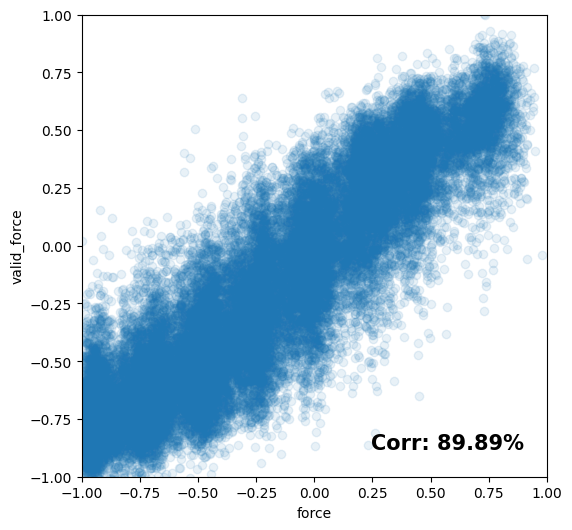

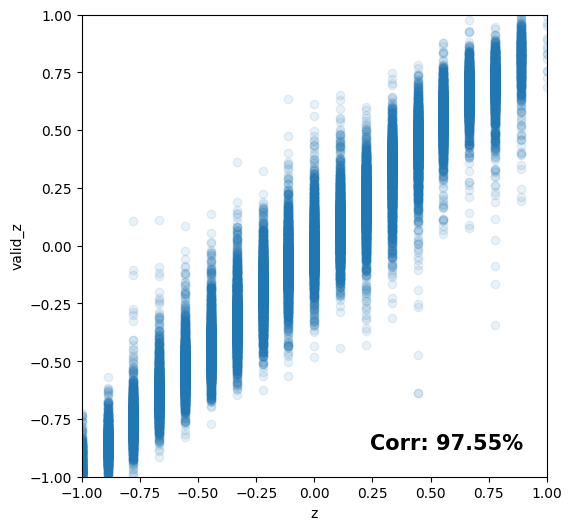

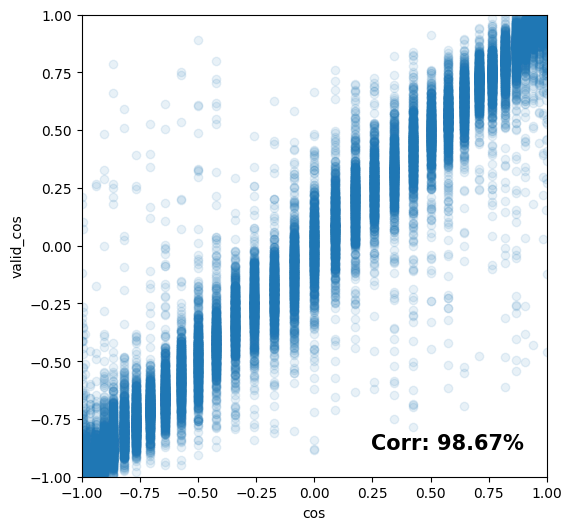

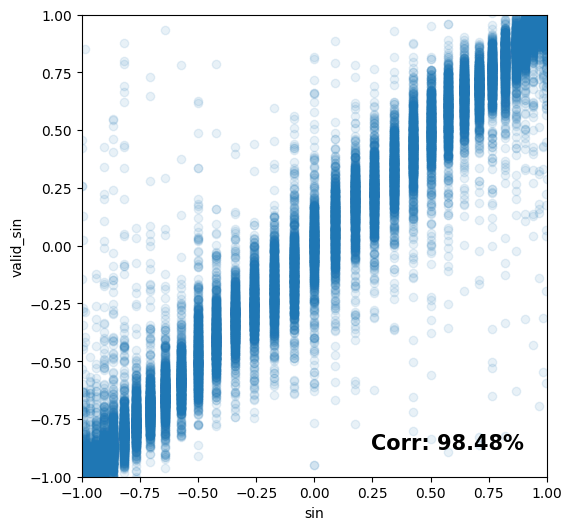

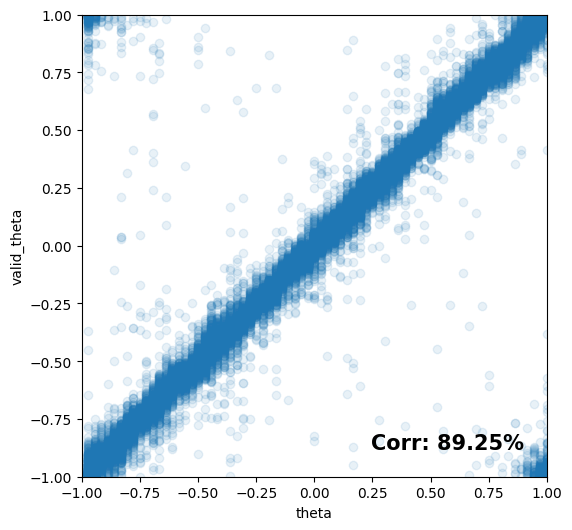

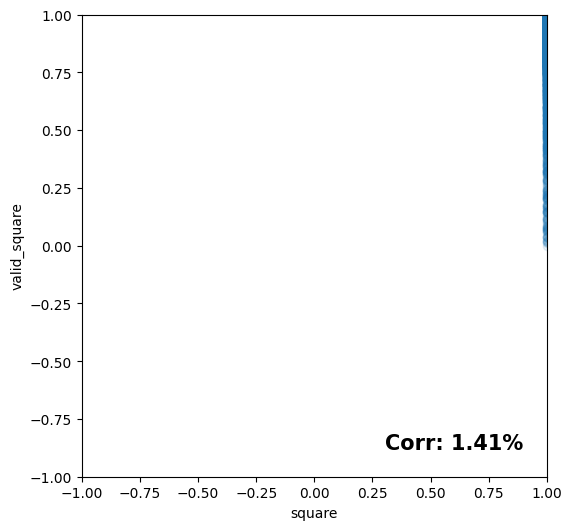

In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['force','z','cos','sin','theta','square']
#fields = ['force','z','r','cos','sin','theta']
#fields = ['z','cos','sin','theta','square']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(-1, 1)  # x축 범위 설정
    plt.ylim(-1, 1)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()


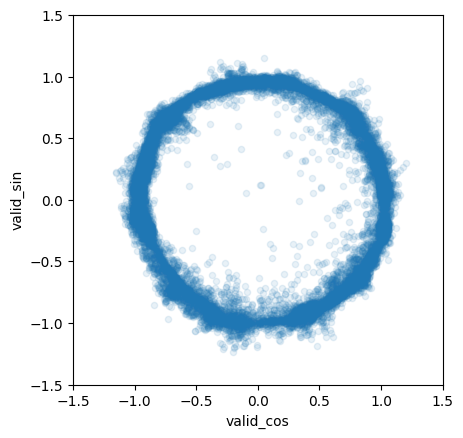

In [18]:
alpa = 0.1  # assuming you've set alpha to this value, adjust as needed
ax = ValidPre.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpa)

# Set the aspect ratio to be equal
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

# Display the plot
plt.show()

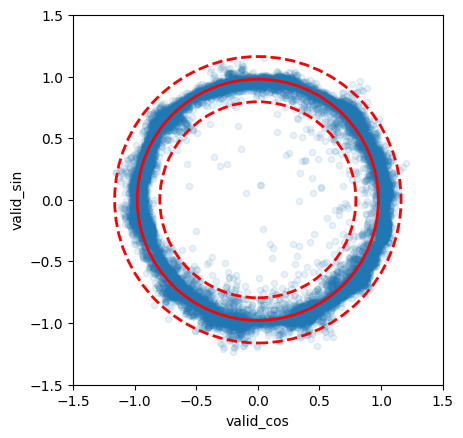

In [19]:
alpha = 0.1  # set alpha value for scatter plot
ax = ValidPre.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)


# Draw offset circles (one inside and one outside the main circle)

circle = plt.Circle((0, 0), avg, color='r', fill=False, linewidth=2)
ax.add_artist(circle)
inner_circle = plt.Circle((0, 0), avg - n*std, color='r', linestyle='--', fill=False, linewidth=2)
outer_circle = plt.Circle((0, 0), avg + n*std, color='r', linestyle='--', fill=False, linewidth=2)
ax.add_artist(inner_circle)
ax.add_artist(outer_circle)

# Set the aspect ratio to be equal
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
# Display the plot
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_offset.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

plt.show()


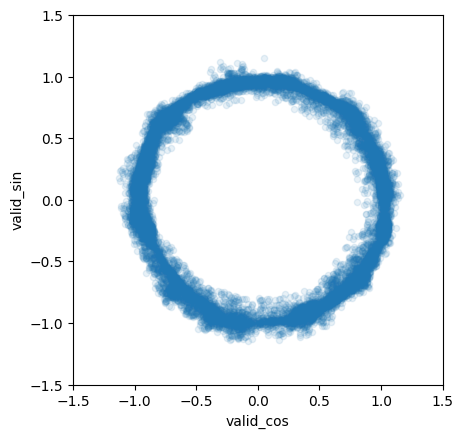

1.4245599616464626

In [20]:
ValidPre_filtered = ValidPre[
    (ValidPre['valid_cos']**2 + ValidPre['valid_sin']**2 <= (avg + n*std)**2) &
    (ValidPre['valid_cos']**2 + ValidPre['valid_sin']**2 >= (avg - n*std)**2)
]


ax = ValidPre_filtered.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_cut.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

plt.show()

total_data_count = len(ValidPre)
filtered_data_count = len(ValidPre_filtered)
percentage_filtered_out = ((total_data_count - filtered_data_count) / total_data_count) * 100
percentage_filtered_out

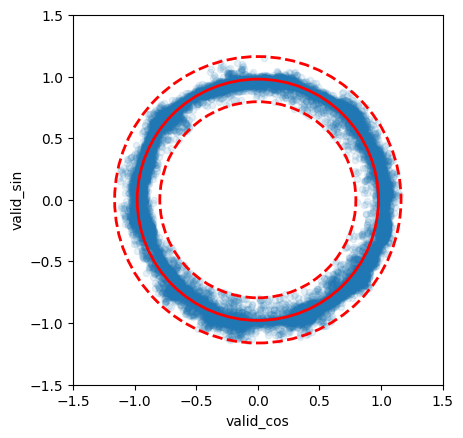

In [21]:
# 기존의 scatter plot을 그립니다.
ax = ValidPre_filtered.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)



# 점선 원을 추가합니다. 하나는 내부에, 하나는 외부에 위치합니다.
circle = plt.Circle((0, 0), avg, color='r', fill=False, linewidth=2)
inner_circle = plt.Circle((0, 0), avg - n*std, color='r', linestyle='--', fill=False, linewidth=2)
outer_circle = plt.Circle((0, 0), avg + n*std, color='r', linestyle='--', fill=False, linewidth=2)
ax.add_artist(circle)
ax.add_artist(inner_circle)
ax.add_artist(outer_circle)

# 그래프의 비율을 1:1로 설정합니다.
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정

# 그래프를 파일로 저장합니다.
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_cut_offset.png"))

# 그래프를 출력합니다.
plt.show()


진행 상태: 100.00%

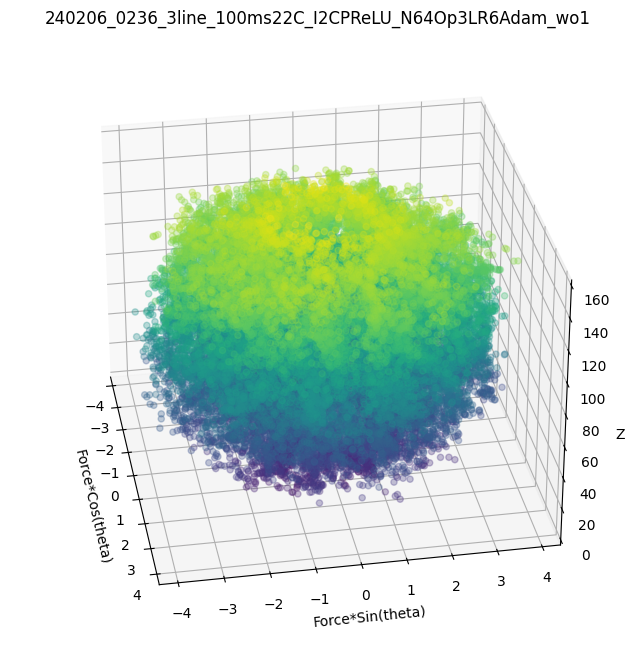

In [18]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()

# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 'Inferno' 색상 맵 적용
cmap = plt.cm.viridis

# z 값을 0과 1 사이로 정규화
norm_z = (ValidPre['valid_z'] - ValidPre['valid_z'].min()) / (ValidPre['valid_z'].max() - ValidPre['valid_z'].min())

# 색상 맵 적용
colors = cmap(norm_z)


# 최소값과 최대값
min_value = min_max_F[0]
max_value = min_max_F[1]

# 원래 값으로 변환
Force = ((ValidPre['valid_force']/2+0.5) * (max_value - min_value)) + min_value
cos = Force*ValidPre['valid_cos']
sin =  Force*ValidPre['valid_sin']
z = ((ValidPre['valid_z']/2+0.5) * (min_max_Z[1] - min_max_Z[0])) + min_max_Z[0] 


ax.scatter(cos, sin, z, c=colors, alpha=0.3)

# 축 레이블 및 한계 설정
ax.set_xlabel('Force*Cos(theta)')
ax.set_ylabel('Force*Sin(theta)')
ax.set_zlabel('Z')
ax.set_xlim([-max_value, max_value])
ax.set_ylim([-max_value, max_value])
ax.set_zlim([0, 160])
ax.set_title(dataname)
 

# 애니메이션 생성 및 저장
nSteps = 10
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)

ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)
ani.save(os.path.join(output_dir, f"{dataname}_3d_scatter_valid_force_colorsss.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))

# 결과 확인
plt.show()


진행 상태: 100.00%

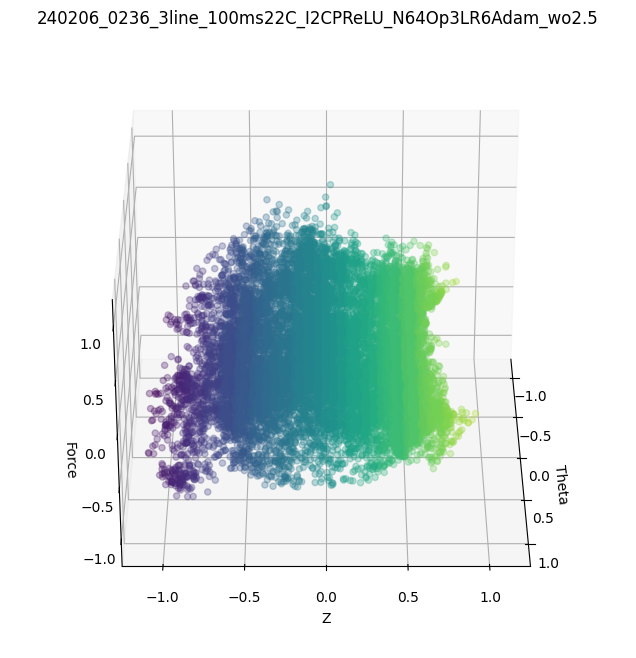

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()
    
    
# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

z_bins = np.arange(-1.2, 1.2, 0.05)

z_indices = np.digitize(ValidPre['valid_z'], z_bins)

# 색상 맵 설정
colors = plt.cm.viridis(np.linspace(0, 1, len(z_bins)))

# 3D 스캐터 플롯 생성
# 각 점에 색상 배열을 적용하기 위해 z_indices-1을 사용
for i in range(1, len(z_bins)):
    subset = ValidPre[z_indices == i]
    ax.scatter(subset['valid_theta'], subset['valid_z'], subset['valid_force'], color=colors[i-1], alpha=0.3)

# 축 레이블 설정
ax.set_xlabel('Theta')
ax.set_ylabel('Z')
ax.set_zlabel('Force')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])
ax.set_title(dataname)


nSteps = 10
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)
# GIF 애니메이션 생성
ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)

# GIF 저장
ani.save(os.path.join(output_dir, f"{dataname}_Ref_plane.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))


In [ ]:
import pandas as pd
from sklearn.cross_decomposition import CCA

# 가정: 'ValidPre' 데이터프레임은 이미 로드되어 있고, 필요한 모든 원시 데이터를 포함하고 있음

# Force, cos, sin, z 값 계산 - 첫 번째 데이터 세트
Force1 = ((ValidPre['valid_force']/2 + 0.5) * (max_value - min_value)) + min_value + 110
cos1 = Force1 * ValidPre['valid_cos']
sin1 = Force1 * ValidPre['valid_sin']
z1 = ((ValidPre['valid_z']/2 + 0.5) * (152 - 8)) + 8

# Force, cos, sin, z 값 계산 - 두 번째 데이터 세트
Force2 = ((ValidPre['force']/2 + 0.5) * (max_value - min_value)) + min_value + 110
cos2 = Force2 * ValidPre['cos']
sin2 = Force2 * ValidPre['sin']
z2 = ((ValidPre['z']/2 + 0.5) * (152 - 8)) + 8

# 데이터프레임 생성
df1 = pd.DataFrame({'ForceCos': Force1*cos1, 'ForceSin': Force1*sin1, 'Z': z1})
df2 = pd.DataFrame({'ForceCos': Force2*cos2, 'ForceSin': Force2*sin2, 'Z': z2})

# 캐노니컬 상관 분석 (CCA) 수행
# CCA 인스턴스 생성, 여기서 n_components는 분석할 컴포넌트 수, 두 데이터 세트의 변수 수에 맞게 설정
cca = CCA(n_components=min(df1.shape[1], df2.shape[1]))

# CCA 적합
cca.fit(df1, df2)

# 결과 변환
df1_c, df2_c = cca.transform(df1, df2)

# CCA 결과 출력
print("Canonical Correlation per component:")
for i, (cc1, cc2) in enumerate(zip(df1_c.T, df2_c.T), start=1):
    corr = np.corrcoef(cc1, cc2)[0, 1]
    print(f"Component {i}: {corr:.3f}")


진행 상태: 100.00%

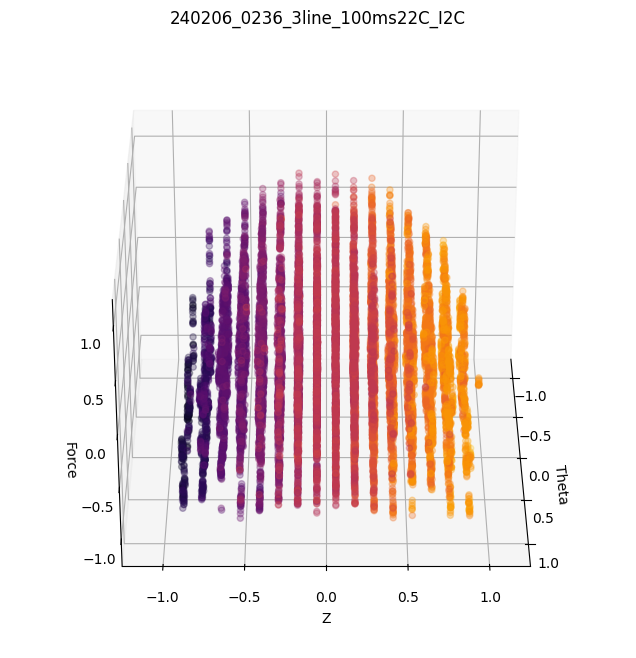

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()
    
# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

z_bins = np.arange(-1.2, 1.2, 0.05)

z_indices = np.digitize(ValidPre['valid_z'], z_bins)

# 색상 맵 설정
colors = plt.cm.inferno(np.linspace(0, 1, len(z_bins)))

# 3D 스캐터 플롯 생성
# 각 점에 색상 배열을 적용하기 위해 z_indices-1을 사용
for i in range(1, len(z_bins)):
    subset = ValidPre[z_indices == i]
    ax.scatter(subset['theta'], subset['z'], subset['force'], color=colors[i-1], alpha=0.3)

# 축 레이블 설정
ax.set_xlabel('Theta')
ax.set_ylabel('Z')
ax.set_zlabel('Force')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])
ax.set_title(data)


nSteps = 10
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)
# GIF 애니메이션 생성
ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)

# GIF 저장
ani.save(os.path.join(output_dir, f"{dataname}_Ref.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))


진행 상태: 100.00%

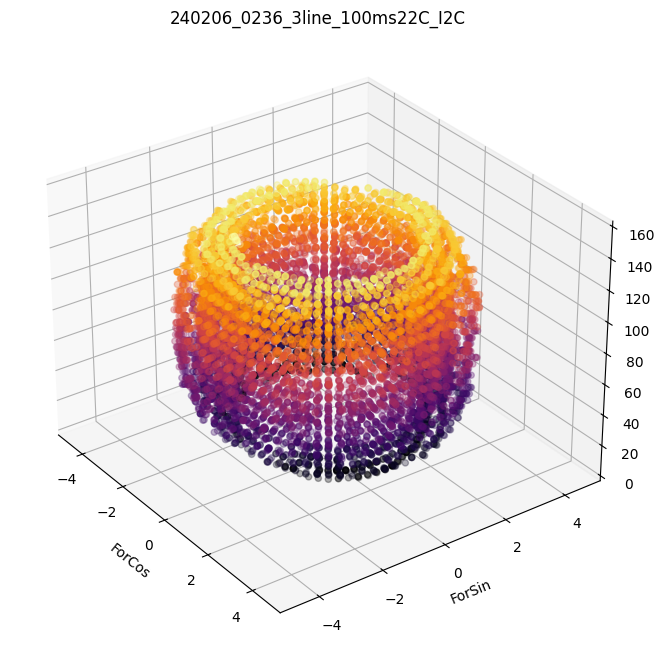

In [32]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()

# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 'Inferno' 색상 맵 적용
cmap = plt.cm.inferno

# z 값을 0과 1 사이로 정규화
norm_z = (ValidPre['z'] - ValidPre['z'].min()) / (ValidPre['z'].max() - ValidPre['z'].min())

# 색상 맵 적용
colors = cmap(norm_z)


# 최소값과 최대값
min_value = min_max_F[0]
max_value = min_max_F[1]

# 원래 값으로 변환
Force = ((ValidPre['force']/2+0.5) * (max_value - min_value)) + min_value 
cos = Force*ValidPre['cos']
sin =  Force*ValidPre['sin']
z = ((ValidPre['z']/2+0.5) * (min_max_Z[1] - min_max_Z[0])) + min_max_Z[0] 


ax.scatter(cos, sin, z, c=colors, alpha=0.3)

# 축 레이블 및 한계 설정
ax.set_xlabel('ForCos')
ax.set_ylabel('ForSin')
ax.set_zlabel('Z')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([0, 160])
ax.set_title(data)

 

# 애니메이션 생성 및 저장
nSteps = 36
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)

ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)
ani.save(os.path.join(output_dir, f"{dataname}_3d_scatter_Ref_force_color.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))

# 결과 확인
plt.show()


진행 상태: 100.00%

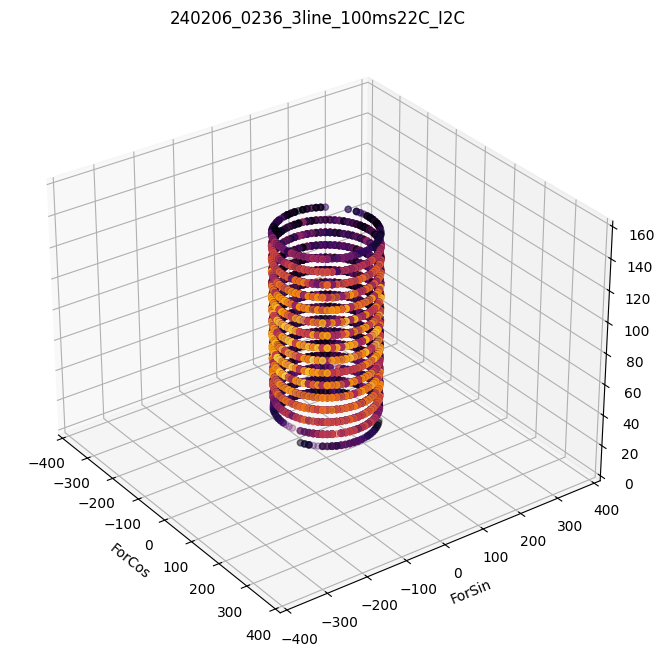

In [27]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()

# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 'Inferno' 색상 맵 적용
cmap = plt.cm.inferno

# z 값을 0과 1 사이로 정규화
norm_force = (ValidPre['force'] - ValidPre['force'].min()) / (ValidPre['force'].max() - ValidPre['force'].min())
norm_force = norm_force
# 색상 맵 적용
colors = cmap(norm_force)


# 최소값과 최대값
min_value = min_max_F[0]
max_value = min_max_F[1]

# 원래 값으로 변환
Force = ((ValidPre['force']/2+0.5) * (max_value - min_value)) + min_value  +110
cos = Force*ValidPre['cos']
sin =  Force*ValidPre['sin']
z = ((ValidPre['z']/2+0.5) * (min_max_Z[1] - min_max_Z[0])) + min_max_Z[0] 


ax.scatter(cos, sin, z, c=colors, alpha=0.3)

# 축 레이블 및 한계 설정
ax.set_xlabel('ForCos')
ax.set_ylabel('ForSin')
ax.set_zlabel('Z')
ax.set_xlim([-400, 400])
ax.set_ylim([-400, 400])
ax.set_zlim([0, 160])
ax.set_title(dataname)



 

# 애니메이션 생성 및 저장
nSteps = 36
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)

ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)
ani.save(os.path.join(output_dir, f"{dataname}_3d_scatter_Ref_force2.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))

# 결과 확인
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()

# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 'Inferno' 색상 맵 적용
cmap = plt.cm.viridis

# z 값을 0과 1 사이로 정규화
norm_force = (ValidPre['valid_force'] - ValidPre['valid_force'].min()) / (ValidPre['valid_force'].max() - ValidPre['valid_force'].min())
norm_force =  norm_force

# 색상 맵 적용
colors = cmap(norm_force)


# 최소값과 최대값
min_value = min_max_F[0]
max_value = min_max_F[1]

# 원래 값으로 변환
Force = ((ValidPre['valid_force']/2+0.5) * (max_value - min_value)) + min_value  +110
cos = Force*ValidPre['valid_cos']
sin =  Force*ValidPre['valid_sin']
z = ((ValidPre['valid_z']/2+0.5) * (min_max_Z[1] - min_max_Z[0])) + min_max_Z[0] 


ax.scatter(cos, sin, z, c=colors, alpha=0.3)

# 축 레이블 및 한계 설정
ax.set_xlabel('ForCos')
ax.set_ylabel('ForSin')
ax.set_zlabel('Z')
ax.set_xlim([-400, 400])
ax.set_ylim([-400, 400])
ax.set_zlim([0, 160])
ax.set_title(dataname)



 

# 애니메이션 생성 및 저장
nSteps = 360
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)

ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)
ani.save(os.path.join(output_dir, f"{dataname}_3d_scatter_valid_force_color_2.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))

# 결과 확인
plt.show()


In [ ]:
output_dir